#### Human In The Loop

##### Use cases
Key use cases for human-in-the-loop workflows in LLM-based applications include:
- 🛠️ **Reviewing tool calls:** Humans can review, edit, or approve tool calls requested by the LLM before tool execution.
- ✅ **Validating LLM outputs:** Humans can review, edit, or approve content generated by the LLM.
- 💡 **Providing context:** Enable the LLM to explicitly request human input for clarification or additional details or to support multi-turn conversations.

In [1]:
# Importing Necessary Libraries
import os
from dotenv import load_dotenv
from typing import Annotated
import operator,json
from typing import TypedDict, Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph,END,START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_groq import ChatGroq
from langgraph.types import Command, interrupt
load_dotenv()

True

In [2]:
# Setting the environment variables
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [3]:
# Import the LLM model
llm = ChatGroq(model_name="Gemma2-9b-It")

In [4]:
llm.invoke("Hi").content

'Hi there! 👋 \n\nWhat can I do for you today?\n'

##### Langgraph human-in-the-loop concept --> Custom built

In [5]:
@tool
def multiply(first_number:int,second_number:int)->int:
    """multiply first_number with second_number and return the results"""
    return first_number * second_number

In [6]:
multiply.invoke({'first_number':10,'second_number':20})

200

In [7]:
@tool
def search(query:str):
    """perform the web search based on the query"""
    tavily = TavilySearchResults()
    result = tavily.invoke(query)
    return result

print(search.invoke("Who is the current president of India"))

[{'url': 'http://www.presidentofindia.gov.in/Profile', 'content': '#### Smt. Droupadi MurmuThe President of India Smt. Droupadi Murmu was sworn in as the 15th President of India on 25 July, 2022. Born in a Santhali tribal family on 20 June, 1958 at Uparbeda village, Mayurbhanj, Odisha, Smt. Murmu’s early life was marked by hardships and struggle. In 2000, Smt. Murmu was elected from the Rairangpur constituency as a Member of the Legislative Assembly of Odisha and continued to hold the post till 2009, serving two terms. Smt. Murmu was appointed the Governor of Jharkhand on 18 May, 2015. Smt. Murmu was associated with several tribal socio-educational and cultural organisations of Odisha. As President of India, Smt. Droupadi Murmu has travelled widely across the country.'}, {'url': 'https://en.wikipedia.org/wiki/President_of_India', 'content': 'Article 53 of the Constitution of India states that the president can exercise their powers directly or by subordinate authority, though all of th

In [8]:
tools = [search,multiply]
llm_with_tools = llm.bind_tools(tools)

In [9]:
tool_mapping = {tool.name:tool for tool in tools}
tool_mapping

{'search': StructuredTool(name='search', description='perform the web search based on the query', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000001849E1A8CC0>),
 'multiply': StructuredTool(name='multiply', description='multiply first_number with second_number and return the results', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x000001849E118180>)}

In [18]:
response = llm_with_tools.invoke("who is the PM of India?")
tool_details = response.additional_kwargs.get("tool_calls")
tool_name = tool_details[0].get("function").get('name')

In [19]:
tool_details

[{'id': 'call_w6y7',
  'function': {'arguments': '{"query":"Who is the PM of India?"}',
   'name': 'search'},
  'type': 'function'}]

In [20]:
tool_name

'search'

In [21]:
user_query = json.loads(tool_details[0].get("function").get('arguments'))

In [22]:
tool_mapping[tool_name].invoke(user_query)

[{'url': 'https://archivepmo.nic.in/',
  'content': "Prime Ministers of India Dr. Manmohan Singh Shri Atal Bihari Vajpayee March 19, 1998 - May 22, 2004 April 21, 1997 - March 19, 1998 Shri H. June 1, 1996 - April 21, 1997 Shri P. Shri Chandra Shekhar November 10, 1990 - June 21, 1991 Shri Vishwanath Pratap Singh December 2, 1989 - Nov. 10, 1990 Shri Rajiv Gandhi October 31, 1984 - December 2, 1989 Mrs. Indira Gandhi January 14, 1980 - October 31, 1984 January 24, 1966 - March 24, 1977 Shri Charan Singh Shri Morarji Desai March 24, 1977 - July 28, 1979 Shri Gulzari Lal Nanda Shri Lal Bahadur Shastri June 9, 1964 - January 11, 1966 Website Policy Prime Minister's Office Website designed & hosted by"},
 {'url': 'http://www.pmindia.gov.in/en/',
  'content': 'PM’s Visits PM’s Speeches PM’s Speeches (Videos) 07 Feb, 2025The Prime Minister Shri Narendra Modi chaired an extensive meeting of the Advisory Board of WAVES through Video Conference today. 07 Feb, 2025Hailing Shri Akkineni Nageswar 

In [23]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage],operator.add]

In [24]:
def invoke_model(state:AgentState):
    messages = state["messages"]
    question = messages[-1]
    return {"messages":[llm_with_tools.invoke(question)]}

In [25]:
def invoke_tool(state:AgentState):
    tool_details = state['messages'][-1].additional_kwargs.get("tool_calls", [])[0]
    tool_name = state['messages'][-1].additional_kwargs.get("tool_calls", [])[0].get('function').get('name')
    
    if tool_details is None:
        raise Exception("No tool call found")
    print(f"selected tool : {tool_name}")
    
    if tool_name == 'search':
        response = input(prompt=f"Y/N continue with expensive web search")
        if response.lower() == 'n':
            print("You have decided not search on web.")
            return
    
    query = json.loads(tool_details.get('function').get('arguments'))
    print("Query",query)
    response = tool_mapping[tool_name].invoke(query)
    return {"messages":[response]}

In [26]:
def router(state:AgentState):
    tool_calls = state["messages"][-1].additional_kwargs.get("tool_calls", [])
    if len(tool_calls):
        return 'tool'
    return 'end'

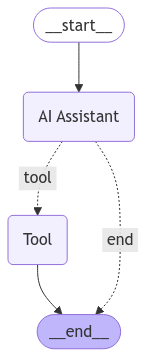

In [27]:
graph = StateGraph(AgentState)
graph.add_node("AI Assistant",invoke_model)
graph.add_node("Tool",invoke_tool)
graph.add_conditional_edges("AI Assistant",router,{"tool":"Tool","end":END})
graph.add_edge("Tool",END)
graph.set_entry_point("AI Assistant")
app = graph.compile()
app

In [28]:
for s in app.stream({"messages": ["Who is PM of India"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_pw59', 'function': {'arguments': '{"query":"Who is the PM of India"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 85, 'prompt_tokens': 1081, 'total_tokens': 1166, 'completion_time': 0.154545455, 'prompt_time': 0.060134265, 'queue_time': 0.054676989, 'total_time': 0.21467972}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1d272077-b9bf-4e31-88ec-fccd836ec011-0', tool_calls=[{'name': 'search', 'args': {'query': 'Who is the PM of India'}, 'id': 'call_pw59', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1081, 'output_tokens': 85, 'total_tokens': 1166})]}
----
selected tool : search
Query {'query': 'Who is the PM of India'}
{'messages': [[{'url': 'https://www.jagranjosh.com/general-knowledge/list-of-all-prime-ministers-of-india-1473165149-1', 'content': "List of All 

In [112]:
for s in app.stream({"messages": ["No of states present in India"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4epx', 'function': {'arguments': '{"query":"Number of states in India"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 84, 'prompt_tokens': 1082, 'total_tokens': 1166, 'completion_time': 0.152727273, 'prompt_time': 0.034657898, 'queue_time': 0.02492412, 'total_time': 0.187385171}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-0e9d5f42-aaad-4bae-943a-7bbb03a2e71a-0', tool_calls=[{'name': 'search', 'args': {'query': 'Number of states in India'}, 'id': 'call_4epx', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1082, 'output_tokens': 84, 'total_tokens': 1166})]}
----
selected tool : search
Query {'query': 'Number of states in India'}
{'messages': [[{'url': 'https://en.wikipedia.org/wiki/List_of_states_and_union_territories_of_India_by_area', 'content': 'India consists

In [29]:
for s in app.stream({"messages": ["2 multiplied by 10"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ygm9', 'function': {'arguments': '{"first_number":2,"second_number":10}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 92, 'prompt_tokens': 1083, 'total_tokens': 1175, 'completion_time': 0.167272727, 'prompt_time': 0.044766435, 'queue_time': 0.052554975999999996, 'total_time': 0.212039162}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-8e70baaf-0cbd-418a-a36d-b405071c5734-0', tool_calls=[{'name': 'multiply', 'args': {'first_number': 2, 'second_number': 10}, 'id': 'call_ygm9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1083, 'output_tokens': 92, 'total_tokens': 1175})]}
----
selected tool : multiply
Query {'first_number': 2, 'second_number': 10}
{'messages': [20]}
----


##### Langgraph Human-In-The-Loop concept --> Built-in method

In [30]:
# Defined the message state
class AgentState(TypedDict):
    messages:Annotated[list,add_messages]

In [31]:
tavily = TavilySearchResults()
llm_with_tools = llm.bind_tools([tavily])

In [32]:
def AI_assitant(state:AgentState):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [33]:
memory = MemorySaver()

graph_builder = StateGraph(AgentState)
graph_builder.add_node("ai_assistant", AI_assitant)

tool_node = ToolNode(tools=[tavily])
graph_builder.add_node("tools", tool_node)
graph_builder.add_edge(START, "ai_assistant")
graph_builder.add_conditional_edges(
    "ai_assistant",
    tools_condition,
)
graph_builder.add_edge("tools", "ai_assistant")

In [34]:
# interrupt_before tools
app = graph_builder.compile(checkpointer=memory,interrupt_before=["tools"],)

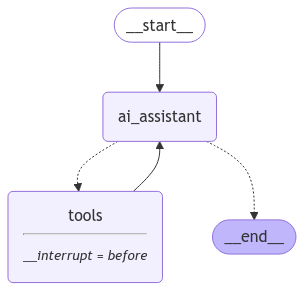

In [35]:
app

In [36]:
user_input = "What is the capital of Dhule"
config = {"configurable":{"thread_id":1}}

In [37]:
events = app.stream({"messages":[("user",user_input)]},config,stream_mode="values")
# print(events)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the capital of Dhule
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_nswd)
 Call ID: call_nswd
  Args:
    query: capital of Dhule


In [38]:
# Interruption before the tools
snapshot = app.get_state(config)
snapshot.next

('tools',)

In [39]:
last_message = snapshot.values["messages"][-1]
last_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'capital of Dhule'},
  'id': 'call_nswd',
  'type': 'tool_call'}]

In [40]:
events = app.stream(None,config,stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_nswd)
 Call ID: call_nswd
  Args:
    query: capital of Dhule
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://en.wikipedia.org/wiki/Dhule_district", "content": "Dhule district is a district of Maharashtra, India. The city of Dhule is the administrative headquarters of the district. It is part of North Maharashtra."}, {"url": "https://en.wikipedia.org/wiki/Dhule", "content": "Dhule Dhule Dhule Location of Dhule City in Maharashtra state Dhule is one of the largest cities in Maharashtra, and central region of India. The city located in the Dhule District in the northwestern part of Maharashtra state, India known as West Khandesh. Dhule city is also a part of Delhi Mumbai Industrial Corridor Project, as Node – 17, India's most ambitious infrastructure program, aiming to develop n

##### Human in the loop : Langgraph Documentation

Calling `interrupt` inside a node will pause execution. Execution can be resumed, together with new input from a human, by passing in a `Command`

In [5]:
# Defined the message state
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Initialized the graph
graph_builder = StateGraph(State)

# Define the feedback tool
@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

# Define the another tool
tavily_tool = TavilySearchResults(max_results=2)
tools = [tavily_tool, human_assistance]

# Define the LLM
llm = ChatGroq(model_name="Gemma2-9b-It",temperature=0)

# Binding the tools to the LLM
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# compile the graph 
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

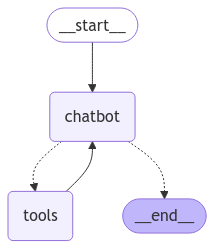

In [6]:
graph

In [7]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

In [19]:
# Invoked the model
response = graph.invoke({'messages':user_input},config)

In [20]:
if response["messages"][-1].tool_calls:
    print(True)

True


In [21]:
response["messages"][-1].tool_calls

[{'name': 'human_assistance',
  'args': {'query': 'I need some expert guidance for building an AI agent. Could you request assistance for me?'},
  'id': 'call_q736',
  'type': 'tool_call'}]

In [16]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [22]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)
human_command = Command(resume={'data':human_response})
response = graph.invoke(human_command,config)

In [23]:
response

{'messages': [HumanMessage(content='I need some expert guidance for building an AI agent. Could you request assistance for me?', additional_kwargs={}, response_metadata={}, id='36d84eeb-6150-4491-855b-3ead48f1b63b'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_37wp', 'function': {'arguments': '{"query":"I need some expert guidance for building an AI agent. Could you request assistance for me?"}', 'name': 'human_assistance'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 96, 'prompt_tokens': 1101, 'total_tokens': 1197, 'completion_time': 0.174545455, 'prompt_time': 0.045627596, 'queue_time': 0.088425627, 'total_time': 0.220173051}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-83fbc7d3-48ed-4d71-ae71-b1d084318a29-0', tool_calls=[{'name': 'human_assistance', 'args': {'query': 'I need some expert guidance for building an AI agent. Could you request a